# Projet 5 - Catégorisez automatiquement des questions

## Partie 1 -- Exploration

### Espace de bibliothèques

In [2]:
import IPython.display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import seaborn as sb
import time
import mglearn
import pyLDAvis.gensim_models
import warnings
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
from sklearn.model_selection import train_test_split

/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload


In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
warnings.filterwarnings("ignore", category=FutureWarning)

### Espace de fonctions

In [5]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/fayz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /home/fayz/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/fayz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/fayz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text


In [10]:
def len_col(df, nom_col):
    nom = "len_"+nom_col
    l = df.shape[0]
    df[nom] = 0
    for i in range(l):
        df.loc[i,nom] = len(df.loc[i,nom_col])

In [11]:
def tup_type(df):
    tup_int64 = []
    tup_obj = []
    tup_float64 = []
    for i in range(len(df.columns)):
        if(df[df.columns[i]].dtype == 'int64'):
            tup_int64.append(df.columns[i])
        elif(df[df.columns[i]].dtype == 'float64'):
            tup_float64.append(df.columns[i])
        else:
            tup_obj.append(df.columns[i])
    print("In order : int64, obj, float64")
    return tup_int64, tup_obj, tup_float64

### Dataset

In [12]:
df = pd.read_csv("/home/fayz/Documents/OpenClassrooms/Projet5/QueryResults.csv")

### Analyse exploratoire

In [11]:
df.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount
0,Print array without brackets and commas,<p>I'm porting a Hangman game to Android and h...,<java><android><arrays><list><collections>,4389480,55,192840,17,12
1,"Allen Holub wrote ""You should never use get/se...","<p>Allen Holub wrote the following,</p>\n\n<bl...",<language-agnostic><oop><immutability><setter>...,996179,51,9946,26,13
2,How do you get a directory listing in C?,<p>How do you scan a directory for folders and...,<c><file><directory><cross-platform><common-ta...,12489,68,138108,22,9
3,Returning DataTables in WCF/.NET,<p>I have a WCF service from which I want to r...,<c#><.net><wcf><web-services><datatable>,12702,51,56351,12,8
4,Element not visible error (not able to click a...,"<p>I want to click on a radio button, appears ...",<javascript><angularjs><selenium><selenium-web...,37809915,43,44978,21,1


In [12]:
df.loc[2,"Tags"].replace(' ','').replace('<','').replace('>',' ').split(' ')

['c', 'file', 'directory', 'cross-platform', 'common-tasks', '']

In [13]:
df.shape

(27528, 8)

### Valeurs manquantes

In [14]:
df.isna().sum()

Title            0
Body             0
Tags             0
Id               0
Score            0
ViewCount        0
FavoriteCount    0
AnswerCount      0
dtype: int64

### Création de nouvelles variables

In [15]:
len_col(df,"Title")

In [16]:
len_col(df,"Body")

### Analyse unvariée

In order : int64, obj, float64


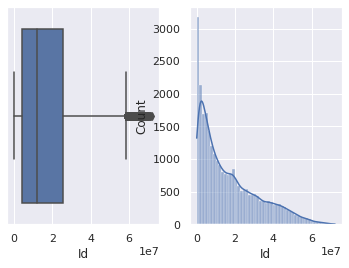

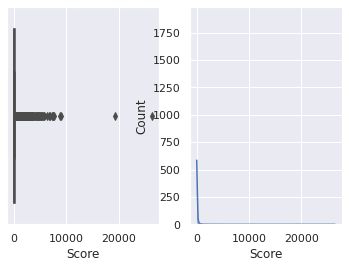

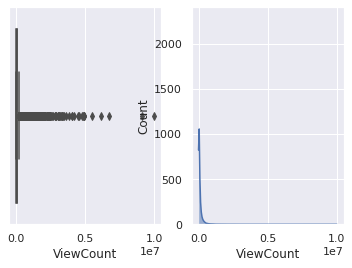

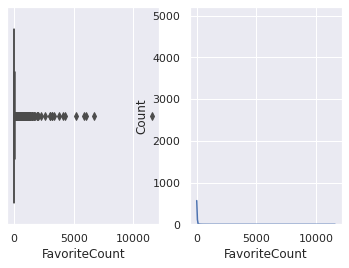

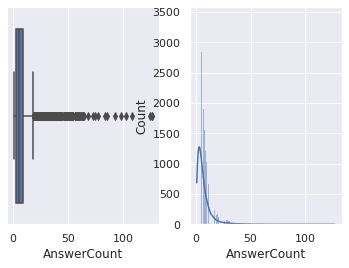

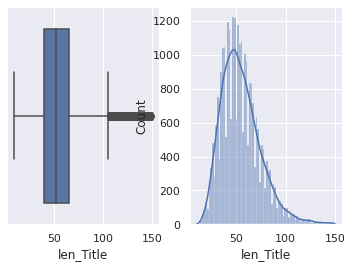

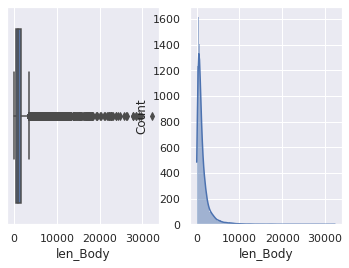

In [17]:
sb.set(rc={'figure.figsize':(16,6)})
for i in tup_type(df)[0]:
    fig, axes = plt.subplots(1,2)
    sb.boxplot(x= df.loc[:,i], ax = axes[0])
    sb.histplot(df.loc[:,i], kde = True, ax = axes[1])
    plt.show()

In [18]:
%%time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27528 entries, 0 to 27527
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          27528 non-null  object
 1   Body           27528 non-null  object
 2   Tags           27528 non-null  object
 3   Id             27528 non-null  int64 
 4   Score          27528 non-null  int64 
 5   ViewCount      27528 non-null  int64 
 6   FavoriteCount  27528 non-null  int64 
 7   AnswerCount    27528 non-null  int64 
 8   len_Title      27528 non-null  int64 
 9   len_Body       27528 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 2.1+ MB
CPU times: user 10.8 ms, sys: 1.37 ms, total: 12.2 ms
Wall time: 20.8 ms


In [19]:
tup_type(df)[0]

In order : int64, obj, float64


['Id',
 'Score',
 'ViewCount',
 'FavoriteCount',
 'AnswerCount',
 'len_Title',
 'len_Body']

### Visualisation des Fréquences de tags

In [15]:
%%time
tags = []
for i in range(len(df)):
    tags.append(df['Tags'][i].replace('>','').replace('<',' ').split())

CPU times: user 122 ms, sys: 0 ns, total: 122 ms
Wall time: 121 ms


In [16]:
%%time
words = []
for t in tags:
     words += t
freq_totale = Counter(words)
print(np.array(freq_totale.most_common(10)))

[['python' '3118']
 ['java' '3088']
 ['javascript' '2734']
 ['c#' '2672']
 ['ios' '2406']
 ['android' '2014']
 ['c++' '1846']
 ['.net' '1419']
 ['iphone' '1323']
 ['objective-c' '1297']]
CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 15.6 ms


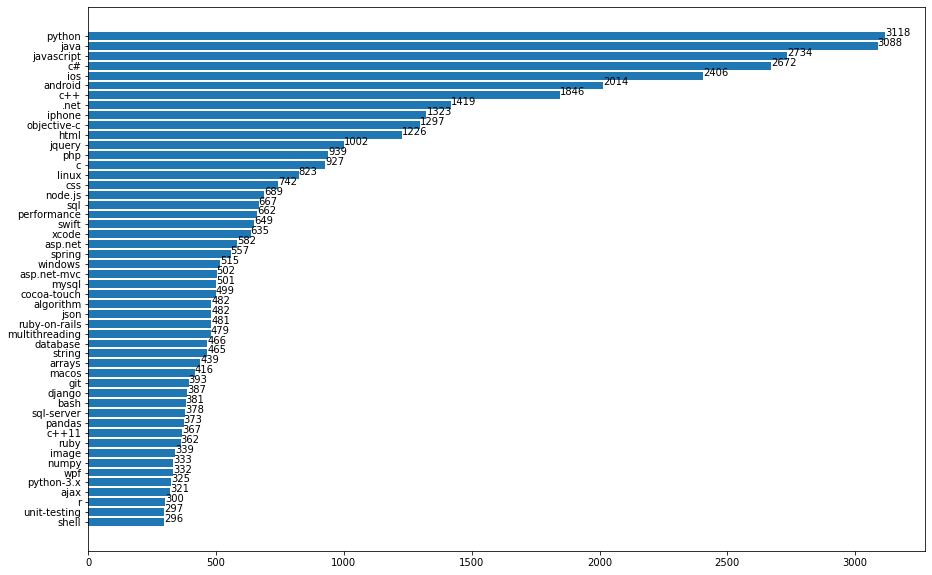

CPU times: user 293 ms, sys: 111 ms, total: 405 ms
Wall time: 260 ms


In [50]:
%%time
nb_titre = 50
plt.figure(figsize=(15,10))
lst = freq_totale.most_common(nb_titre)
df_tags = pd.DataFrame(lst, columns=['Word','Count'])
df_tags = df_tags.sort_values(by = 'Count')
plt.barh(df_tags.Word,df_tags.Count)
#df_words.plot.bar(x = 'Word',y = 'Count', )
for index, value in enumerate(df_tags['Count']):
    plt.text(value, index, str(value))
plt.show()

In [49]:
df_tags[df_tags['Word']=='directory']

,Word,Count
276,directory,74


In [32]:
sum(df_tags.Count)

30243

In [23]:
l_cat = list(set(df['Tags']))
#print("catégories : ", l_cat)

## Nettoyage

### Tokenisation - Stopwords - Lemmatisation

In [24]:
df['Body+Title'] = df['Title']+ ' '+df['Body']

In [25]:
df['sentence_title_bow'] = df['Body+Title'].apply(lambda x : transform_bow_fct(x))
df['sentence_title_bow_lem'] = df['Body+Title'].apply(lambda x : transform_bow_lem_fct(x))
df['sentence__title_dl'] = df['Body+Title'].apply(lambda x : transform_dl_fct(x))
df.shape

(27528, 14)

In [26]:
len_col(df,"sentence_title_bow")
len_col(df,"sentence_title_bow_lem")
len_col(df,"sentence__title_dl")

In [27]:
df.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,len_Title,len_Body,Body+Title,sentence_title_bow,sentence_title_bow_lem,sentence__title_dl,len_sentence_title_bow,len_sentence_title_bow_lem,len_sentence__title_dl
0,Print array without brackets and commas,<p>I'm porting a Hangman game to Android and h...,<java><android><arrays><list><collections>,4389480,55,192840,17,12,39,1079,Print array without brackets and commas <p>I'm...,print array without brackets commas porting ha...,print array without bracket comma porting hang...,print array without brackets and commas < p > ...,747,738,1231
1,"Allen Holub wrote ""You should never use get/se...","<p>Allen Holub wrote the following,</p>\n\n<bl...",<language-agnostic><oop><immutability><setter>...,996179,51,9946,26,13,74,2665,"Allen Holub wrote ""You should never use get/se...",allen holub wrote you never use get set functi...,allen holub wrote you never use get set functi...,allen holub wrote `` you should never use get ...,1856,1818,2904
2,How do you get a directory listing in C?,<p>How do you scan a directory for folders and...,<c><file><directory><cross-platform><common-ta...,12489,68,138108,22,9,40,94,How do you get a directory listing in C? <p>Ho...,how get directory listing how scan directory f...,how get directory listing how scan directory f...,how do you get a directory listing in c ? < p ...,80,77,141
3,Returning DataTables in WCF/.NET,<p>I have a WCF service from which I want to r...,<c#><.net><wcf><web-services><datatable>,12702,51,56351,12,8,32,1466,Returning DataTables in WCF/.NET <p>I have a W...,returning datatables wcf .net wcf service want...,returning datatables wcf .net wcf service want...,returning datatables in wcf .net < p > i have ...,973,971,1558
4,Element not visible error (not able to click a...,"<p>I want to click on a radio button, appears ...",<javascript><angularjs><selenium><selenium-web...,37809915,43,44978,21,1,56,1767,Element not visible error (not able to click a...,element visible error able click element want ...,element visible error able click element want ...,element not visible error ( not able to click ...,1265,1261,2020


In [28]:
print(df.loc[0,["Body+Title","sentence_title_bow"]])

Body+Title            Print array without brackets and commas <p>I'm...
sentence_title_bow    print array without brackets commas porting ha...
Name: 0, dtype: object


In [29]:
%%time
df.loc[0,"sentence_title_bow"]

CPU times: user 77 µs, sys: 7 µs, total: 84 µs
Wall time: 87.5 µs


'print array without brackets commas porting hangman game android met problems the original java program used console somehow beautify output fits android layout. how print array without brackets commas the array contains slashes gets replaced one one correct letter guessed. using usual code .tostring code function code arraylist code class output formatted like code code want simply print array single code string code fill array using bit code pre code list string publicarray new arraylist int secretwordlength hiddenarray.add secretword.substring publicarray.add code pre and print like pre code textview currentwordview textview findviewbyid r.id.currentword currentwordview.settext publicarray.tostring code pre any help would appreciated.'

In [30]:
df.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,len_Title,len_Body,Body+Title,sentence_title_bow,sentence_title_bow_lem,sentence__title_dl,len_sentence_title_bow,len_sentence_title_bow_lem,len_sentence__title_dl
0,Print array without brackets and commas,<p>I'm porting a Hangman game to Android and h...,<java><android><arrays><list><collections>,4389480,55,192840,17,12,39,1079,Print array without brackets and commas <p>I'm...,print array without brackets commas porting ha...,print array without bracket comma porting hang...,print array without brackets and commas < p > ...,747,738,1231
1,"Allen Holub wrote ""You should never use get/se...","<p>Allen Holub wrote the following,</p>\n\n<bl...",<language-agnostic><oop><immutability><setter>...,996179,51,9946,26,13,74,2665,"Allen Holub wrote ""You should never use get/se...",allen holub wrote you never use get set functi...,allen holub wrote you never use get set functi...,allen holub wrote `` you should never use get ...,1856,1818,2904
2,How do you get a directory listing in C?,<p>How do you scan a directory for folders and...,<c><file><directory><cross-platform><common-ta...,12489,68,138108,22,9,40,94,How do you get a directory listing in C? <p>Ho...,how get directory listing how scan directory f...,how get directory listing how scan directory f...,how do you get a directory listing in c ? < p ...,80,77,141
3,Returning DataTables in WCF/.NET,<p>I have a WCF service from which I want to r...,<c#><.net><wcf><web-services><datatable>,12702,51,56351,12,8,32,1466,Returning DataTables in WCF/.NET <p>I have a W...,returning datatables wcf .net wcf service want...,returning datatables wcf .net wcf service want...,returning datatables in wcf .net < p > i have ...,973,971,1558
4,Element not visible error (not able to click a...,"<p>I want to click on a radio button, appears ...",<javascript><angularjs><selenium><selenium-web...,37809915,43,44978,21,1,56,1767,Element not visible error (not able to click a...,element visible error able click element want ...,element visible error able click element want ...,element not visible error ( not able to click ...,1265,1261,2020


### Calcul du gain du nettoyage

In [31]:
df['gain_%'] = round((1-df['len_sentence_title_bow_lem']/df['len_Body'])*100)

In [32]:
df.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,len_Title,len_Body,Body+Title,sentence_title_bow,sentence_title_bow_lem,sentence__title_dl,len_sentence_title_bow,len_sentence_title_bow_lem,len_sentence__title_dl,gain_%
0,Print array without brackets and commas,<p>I'm porting a Hangman game to Android and h...,<java><android><arrays><list><collections>,4389480,55,192840,17,12,39,1079,Print array without brackets and commas <p>I'm...,print array without brackets commas porting ha...,print array without bracket comma porting hang...,print array without brackets and commas < p > ...,747,738,1231,32.0
1,"Allen Holub wrote ""You should never use get/se...","<p>Allen Holub wrote the following,</p>\n\n<bl...",<language-agnostic><oop><immutability><setter>...,996179,51,9946,26,13,74,2665,"Allen Holub wrote ""You should never use get/se...",allen holub wrote you never use get set functi...,allen holub wrote you never use get set functi...,allen holub wrote `` you should never use get ...,1856,1818,2904,32.0
2,How do you get a directory listing in C?,<p>How do you scan a directory for folders and...,<c><file><directory><cross-platform><common-ta...,12489,68,138108,22,9,40,94,How do you get a directory listing in C? <p>Ho...,how get directory listing how scan directory f...,how get directory listing how scan directory f...,how do you get a directory listing in c ? < p ...,80,77,141,18.0
3,Returning DataTables in WCF/.NET,<p>I have a WCF service from which I want to r...,<c#><.net><wcf><web-services><datatable>,12702,51,56351,12,8,32,1466,Returning DataTables in WCF/.NET <p>I have a W...,returning datatables wcf .net wcf service want...,returning datatables wcf .net wcf service want...,returning datatables in wcf .net < p > i have ...,973,971,1558,34.0
4,Element not visible error (not able to click a...,"<p>I want to click on a radio button, appears ...",<javascript><angularjs><selenium><selenium-web...,37809915,43,44978,21,1,56,1767,Element not visible error (not able to click a...,element visible error able click element want ...,element visible error able click element want ...,element not visible error ( not able to click ...,1265,1261,2020,29.0


In [33]:
tup_type(df)

In order : int64, obj, float64


(['Id',
  'Score',
  'ViewCount',
  'FavoriteCount',
  'AnswerCount',
  'len_Title',
  'len_Body',
  'len_sentence_title_bow',
  'len_sentence_title_bow_lem',
  'len_sentence__title_dl'],
 ['Title',
  'Body',
  'Tags',
  'Body+Title',
  'sentence_title_bow',
  'sentence_title_bow_lem',
  'sentence__title_dl'],
 ['gain_%'])

In order : int64, obj, float64


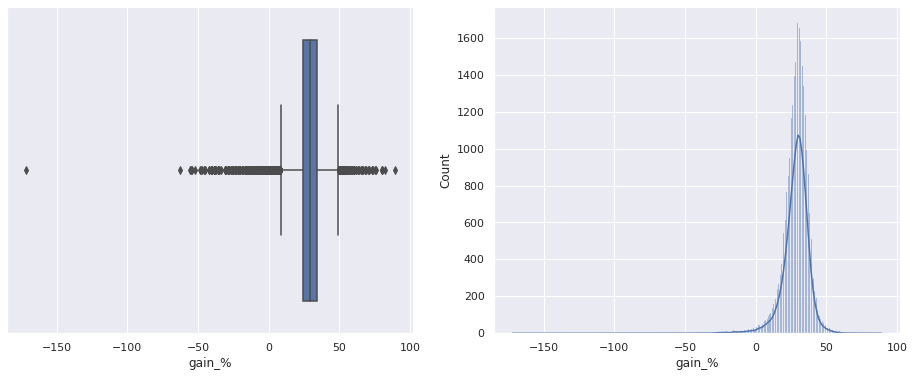

In [34]:
sb.set(rc={'figure.figsize':(16,6)})
for i in tup_type(df)[2]:
    fig, axes = plt.subplots(1,2)
    sb.boxplot(x= df.loc[:,i], ax = axes[0])
    sb.histplot(df.loc[:,i], kde = True, ax = axes[1])
    plt.show()

### Analyse bivariée

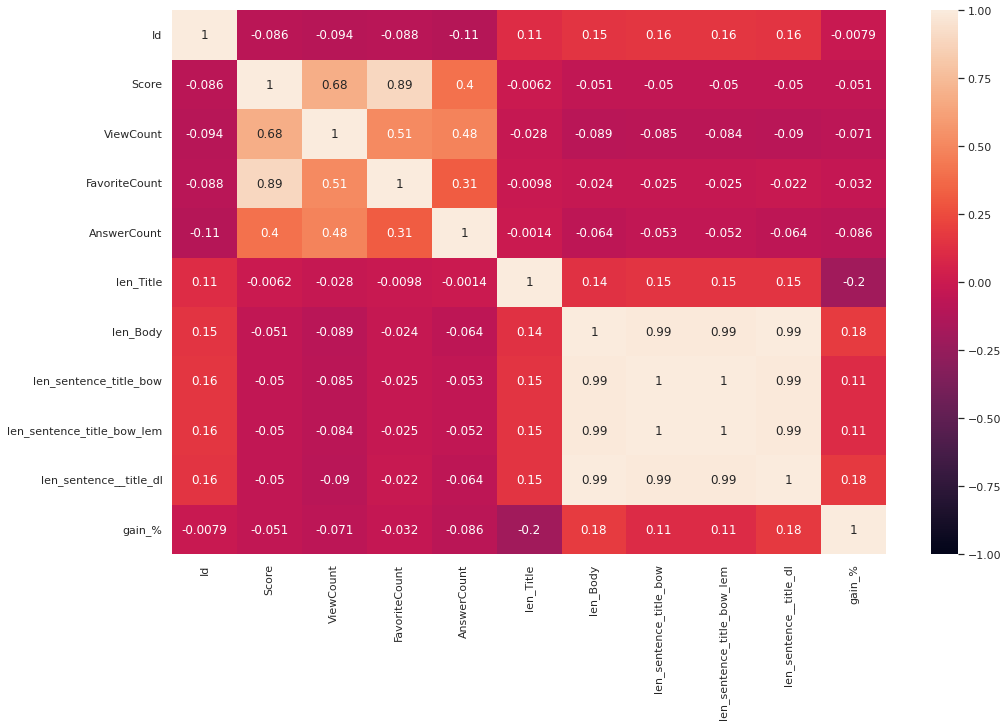

In [35]:
sb.set(rc={'figure.figsize':(16,10)})
sb.heatmap(df.corr(),annot = True, vmin = -1, vmax = 1)
plt.show()

### Fréquence des mots les plus utilisés dans les textes (après nettoyage)

In [36]:
%%time
w = []
for i in range(len(df)):
    w.append(df['sentence_title_bow'][i].split())

CPU times: user 184 ms, sys: 56.1 ms, total: 240 ms
Wall time: 239 ms


In [37]:
%%time
n = 400
words = []
for t in w:
     words += t
freq_totale = Counter(words)
print(np.array(freq_totale.most_common(n)))

[['code' '176152']
 ['pre' '63651']
 ['strong' '32703']
 ['using' '20171']
 ['href=' '19746']
 ["n't" '17761']
 ['like' '15352']
 ['quot' '15316']
 ['use' '15279']
 ['the' '14333']
 ['new' '14320']
 ['how' '13166']
 ['rel=' '12949']
 ['get' '12929']
 ['noreferrer' '12683']
 ['file' '12540']
 ['data' '12480']
 ['would' '11825']
 ['public' '10868']
 ['android' '10669']
 ['error' '10584']
 ['string' '10413']
 ['want' '9613']
 ['way' '9591']
 ['return' '9570']
 ['class' '9565']
 ['one' '9435']
 ['...' '9095']
 ['function' '8950']
 ['app' '8385']
 ['int' '8354']
 ['what' '7843']
 ['user' '7697']
 ['amp' '7615']
 ['need' '7530']
 ['set' '7325']
 ['this' '7275']
 ["'ve" '7207']
 ['server' '6710']
 ['know' '6602']
 ['application' '6568']
 ['image' '6559']
 ['blockquote' '6475']
 ['also' '6272']
 ['time' '6150']
 ['var' '6101']
 ['work' '5962']
 ['following' '5945']
 ['method' '5943']
 ['name' '5924']
 ['example' '5884']
 ['import' '5848']
 ['type' '5693']
 ['could' '5577']
 ['problem' '5545']


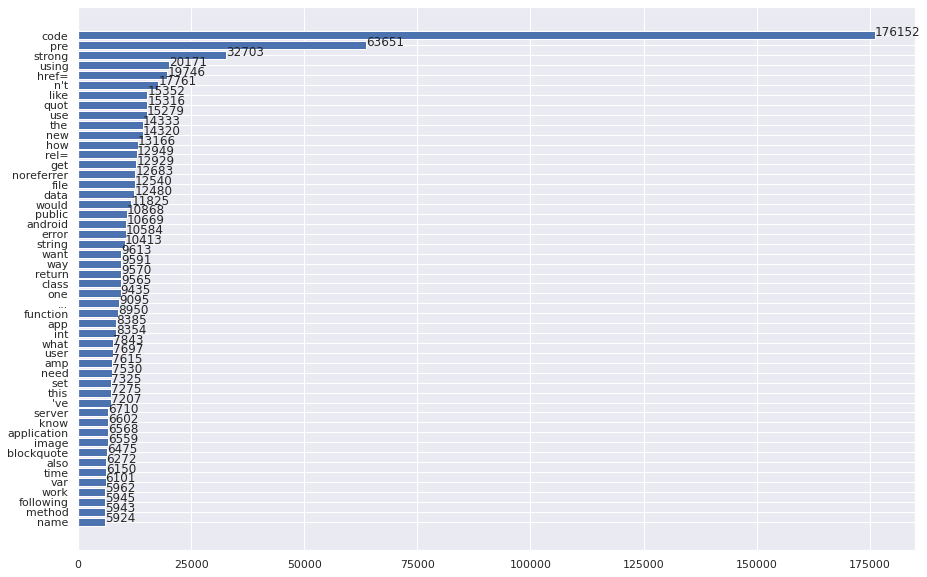

CPU times: user 470 ms, sys: 136 ms, total: 605 ms
Wall time: 453 ms


In [38]:
%%time
nb_titre = 50
plt.figure(figsize=(15,10))
lst = freq_totale.most_common(nb_titre)
df_words = pd.DataFrame(lst, columns=['Word','Count'])
df_words = df_words.sort_values(by = 'Count')
plt.barh(df_words.Word,df_words.Count)
#df_words.plot.bar(x = 'Word',y = 'Count', )
for index, value in enumerate(df_words['Count']):
    plt.text(value, index, str(value))
plt.show()

### Récupération des données cleanées pour modèles

In [39]:
df.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,len_Title,len_Body,Body+Title,sentence_title_bow,sentence_title_bow_lem,sentence__title_dl,len_sentence_title_bow,len_sentence_title_bow_lem,len_sentence__title_dl,gain_%
0,Print array without brackets and commas,<p>I'm porting a Hangman game to Android and h...,<java><android><arrays><list><collections>,4389480,55,192840,17,12,39,1079,Print array without brackets and commas <p>I'm...,print array without brackets commas porting ha...,print array without bracket comma porting hang...,print array without brackets and commas < p > ...,747,738,1231,32.0
1,"Allen Holub wrote ""You should never use get/se...","<p>Allen Holub wrote the following,</p>\n\n<bl...",<language-agnostic><oop><immutability><setter>...,996179,51,9946,26,13,74,2665,"Allen Holub wrote ""You should never use get/se...",allen holub wrote you never use get set functi...,allen holub wrote you never use get set functi...,allen holub wrote `` you should never use get ...,1856,1818,2904,32.0
2,How do you get a directory listing in C?,<p>How do you scan a directory for folders and...,<c><file><directory><cross-platform><common-ta...,12489,68,138108,22,9,40,94,How do you get a directory listing in C? <p>Ho...,how get directory listing how scan directory f...,how get directory listing how scan directory f...,how do you get a directory listing in c ? < p ...,80,77,141,18.0
3,Returning DataTables in WCF/.NET,<p>I have a WCF service from which I want to r...,<c#><.net><wcf><web-services><datatable>,12702,51,56351,12,8,32,1466,Returning DataTables in WCF/.NET <p>I have a W...,returning datatables wcf .net wcf service want...,returning datatables wcf .net wcf service want...,returning datatables in wcf .net < p > i have ...,973,971,1558,34.0
4,Element not visible error (not able to click a...,"<p>I want to click on a radio button, appears ...",<javascript><angularjs><selenium><selenium-web...,37809915,43,44978,21,1,56,1767,Element not visible error (not able to click a...,element visible error able click element want ...,element visible error able click element want ...,element not visible error ( not able to click ...,1265,1261,2020,29.0


In [40]:
df_clean = df.loc[:,["Title","Tags","sentence_title_bow","ViewCount"]]

In [41]:
df_clean.to_csv('/home/fayz/Documents/OpenClassrooms/Projet5/df_clean.csv',index = False)

## Séparation du jeu de données

In [42]:
X = df_clean.copy()
X_train, X_test = train_test_split(X, test_size = 0.2, random_state = 20)

In [43]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis

In [44]:
X_train = X_train.sort_index()

In [45]:
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc = True)
        final.append(new)
    return final
data_words = gen_words(X_train["sentence_title_bow"])
#data_words = gen_words(X_train["Tags"])

In [46]:
X_train['sentence_title_bow'][0][0:90]

'print array without brackets commas porting hangman game android met problems the original'

In [47]:
X_train['Tags'][0][0:90]

'<java><android><arrays><list><collections>'

## Bag of words

In [59]:
vectorizer = TfidfVectorizer(min_df=0.01)
X = vectorizer.fit_transform(X_train["sentence_title_bow"])
vectorizer.get_feature_names_out()
df_bow_sklearn = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
df_bow_sklearn.head()

,00,10,100,1000,11,12,13,14,15,16,...,wrong,wrote,www,x86,xcode,xml,xmlns,yes,yet,you
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.101239,0.146952,0.090472,0.0,0.0,0.0,0.0,0.0,0.0,0.231667
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.086769,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.152729,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [61]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0.01)
X = vectorizer.fit_transform(X_train["sentence_title_bow"])
df_bow_sklearn = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
df_bow_sklearn.head()

,00,10,100,1000,11,12,13,14,15,16,...,wrong,wrote,www,x86,xcode,xml,xmlns,yes,yet,you
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,2,2,2,0,0,0,0,0,0,4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
